
# Project 2

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [105]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import itertools
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated.

#### 1.1. Exploring the data

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
house.shape

(1460, 81)

In [4]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [5]:
#correlation matrix
corrmat = house.corr()
corrmat

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


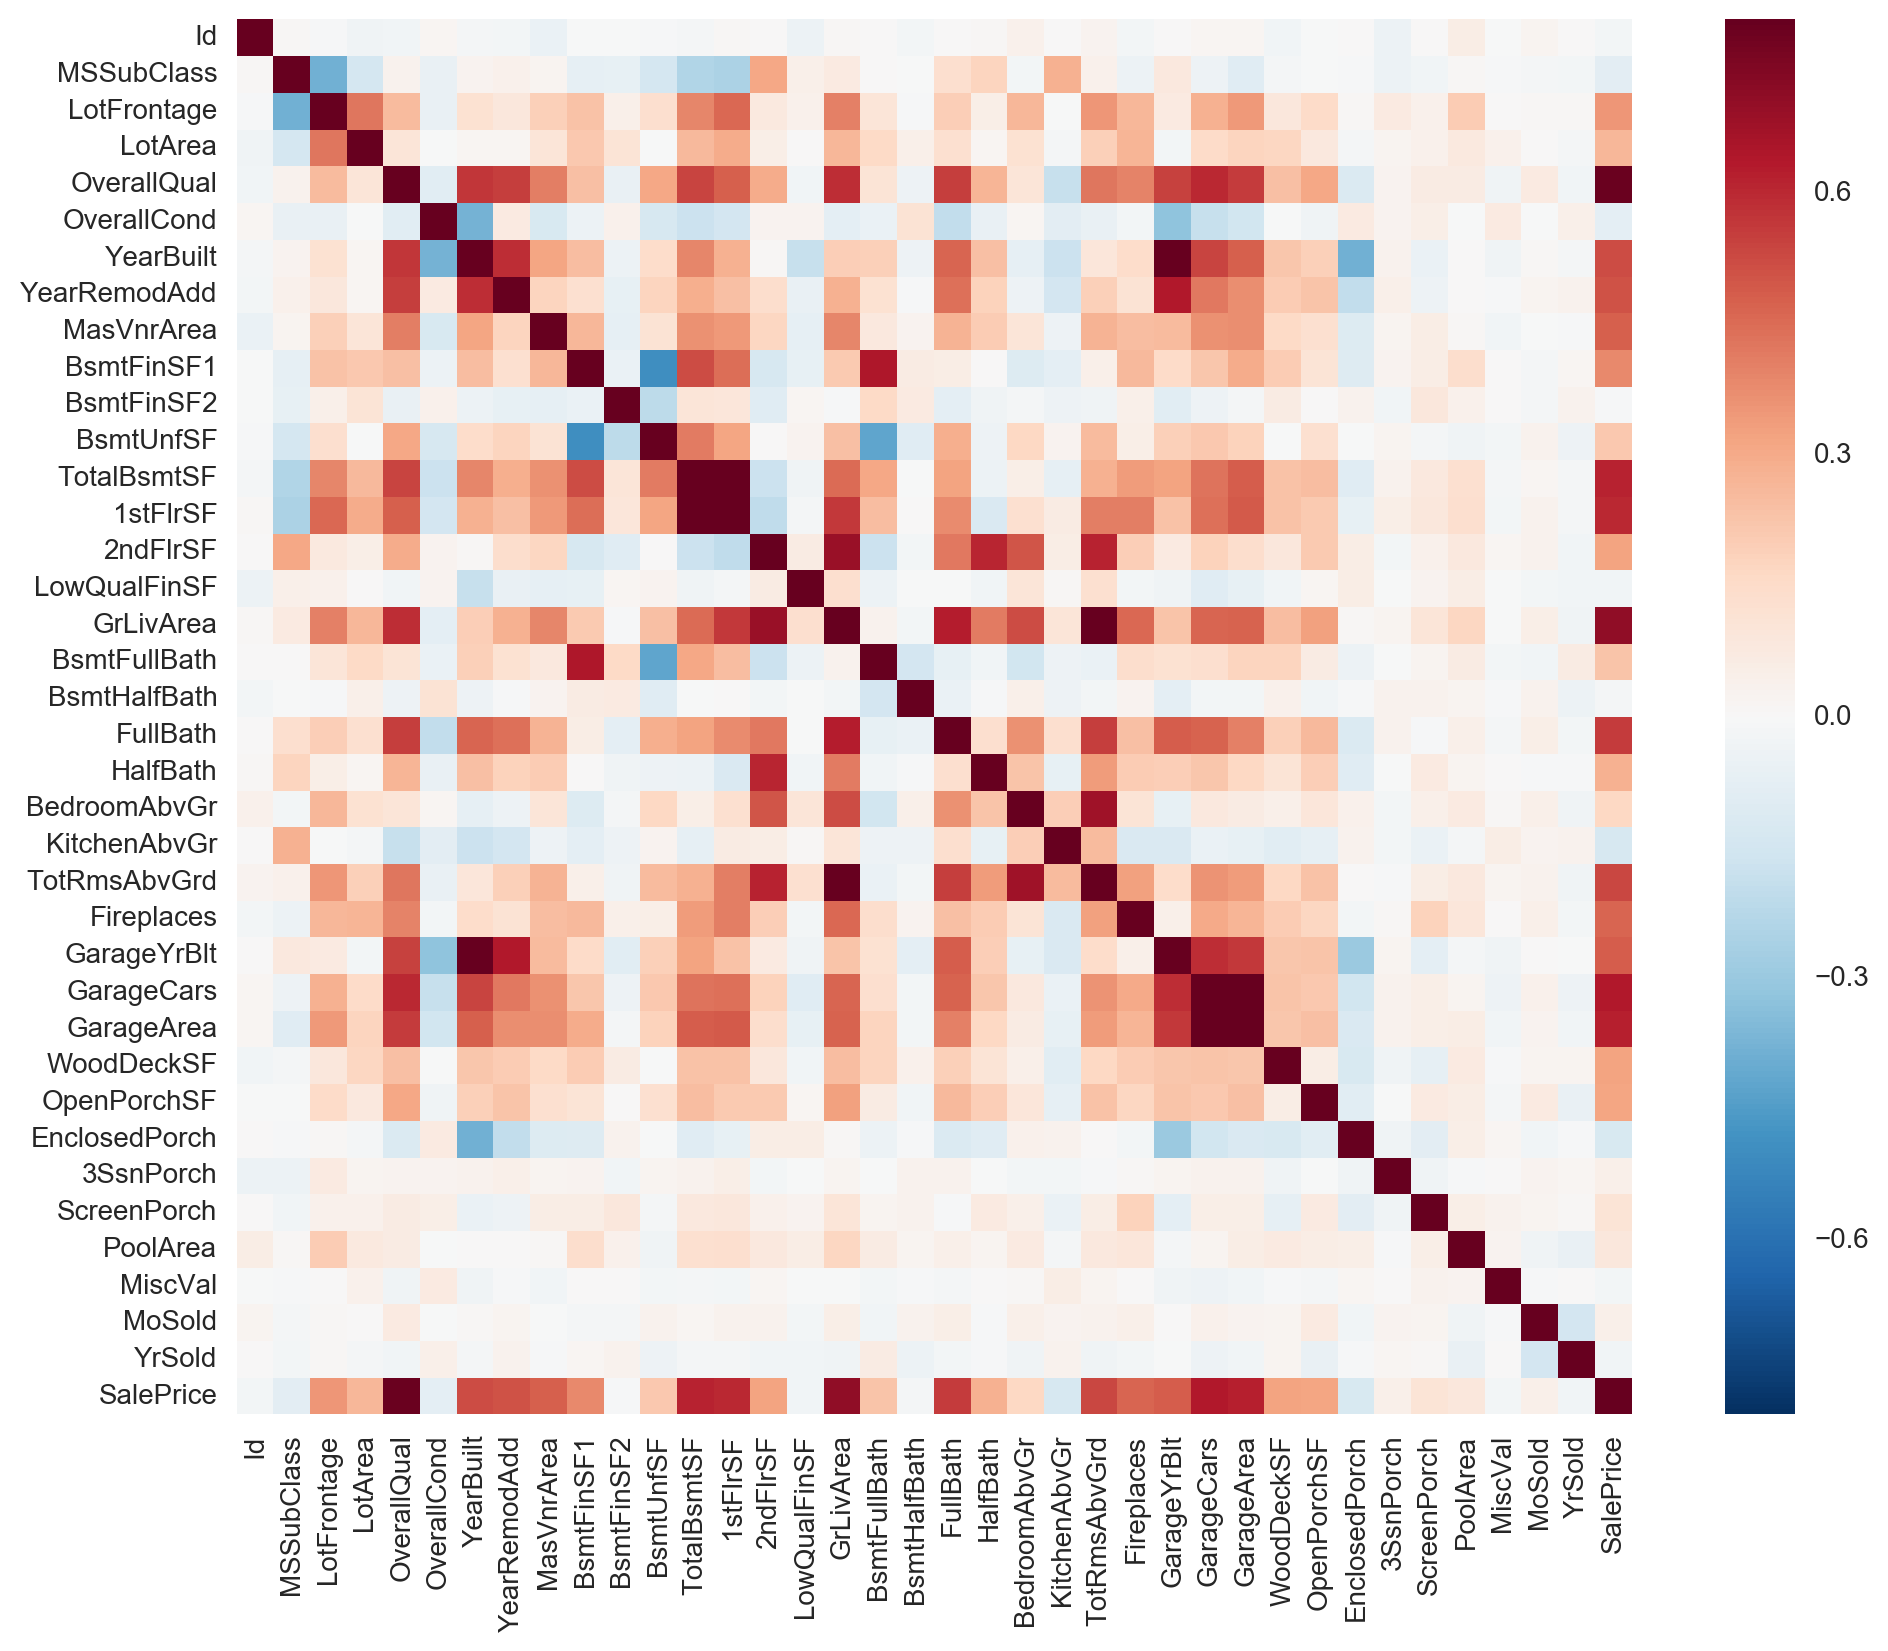

In [6]:
#heatmap
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

#### 1.2. Data cleaning

Firstly, let's remove non residential properties from the set. From the dataframe below we can see that the only non residential property type in the set is "C (all)".

In [7]:
house.groupby(by="MSZoning").count()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSZoning,,,,,,,,,,,,,,,,,,,,,
C (all),10,10,10,10,10,2,10,10,10,10,...,10,0,3,2,10,10,10,10,10,10
FV,65,65,57,65,65,24,65,65,65,65,...,65,0,1,0,65,65,65,65,65,65
RH,16,16,13,16,16,2,16,16,16,16,...,16,0,2,0,16,16,16,16,16,16
RL,1151,1151,922,1151,1151,20,1151,1151,1151,1151,...,1151,7,229,45,1151,1151,1151,1151,1151,1151
RM,218,218,199,218,218,43,218,218,218,218,...,218,0,46,7,218,218,218,218,218,218


Dropping non residential rows:

In [8]:
comm_filter = house["MSZoning"] == "C (all)" #filtering for commercial properties
house = house[~comm_filter]
house.reset_index(drop=True)
house.shape

(1450, 81)

Check for missing data:

In [9]:
no_missing= house.isnull().sum().sort_values(ascending=False)
percentage = (house.isnull().sum()/ house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([no_missing, percentage], axis=1, keys=['Number_Missing', 'Percentage_Missing'])
missing_data.head(15)

,Number_Missing,Percentage_Missing
PoolQC,1443,0.995172
MiscFeature,1398,0.964138
Alley,1361,0.938621
Fence,1172,0.808276
FireplaceQu,681,0.469655
LotFrontage,259,0.178621
GarageCond,79,0.054483
GarageType,79,0.054483
GarageYrBlt,79,0.054483
GarageFinish,79,0.054483


Looking closer at Pool columns:

In [10]:
house[['PoolArea', 'PoolQC']].head()

,PoolArea,PoolQC
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN


Looks like PoolQC has values missing where there is no pool.

In [11]:
house.PoolQC.value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

I'm going to replace NaNs with 0 and other values with 1

In [12]:
house.loc[house["PoolQC"].notnull(), "PoolQC"] = 1
house.loc[house["PoolQC"].isnull(), "PoolQC"] = 0

In [13]:
house.PoolQC.value_counts()

0    1443
1       7
Name: PoolQC, dtype: int64

Repeating the process with Alley, Fence, FireplaceQu and LotFrontage

In [14]:
house.Alley.value_counts()

Grvl    50
Pave    39
Name: Alley, dtype: int64

In [15]:
house.loc[house["Alley"].notnull(), "Alley"] = 1
house.loc[house["Alley"].isnull(), "Alley"] = 0

In [16]:
house.Alley.value_counts()

0    1361
1      89
Name: Alley, dtype: int64

In [17]:
house.Fence.value_counts()

MnPrv    155
GdPrv     59
GdWo      53
MnWw      11
Name: Fence, dtype: int64

In [18]:
house.loc[house["Fence"].notnull(), "Fence"] = 1
house.loc[house["Fence"].isnull(), "Fence"] = 0

In [19]:
house.Fence.value_counts()

0    1172
1     278
Name: Fence, dtype: int64

In [20]:
house.Fence.value_counts()

0    1172
1     278
Name: Fence, dtype: int64

Looking closer at Fireplace columns:

In [21]:
house[['Fireplaces', 'FireplaceQu']].head()

,Fireplaces,FireplaceQu
0,0,NaN
1,1,TA
2,1,TA
3,1,Gd
4,1,TA


In [22]:
house.loc[house["FireplaceQu"].notnull(), "FireplaceQu"] = 1
house.loc[house["FireplaceQu"].isnull(), "FireplaceQu"] = 0

What about MiscFeature?

In [23]:
house.MiscFeature.value_counts()

Shed    47
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [24]:
house.loc[house["MiscFeature"].notnull(), "MiscFeature"] = 1
house.loc[house["MiscFeature"].isnull(), "MiscFeature"] = 0

In [25]:
house.MiscFeature.value_counts()

0    1398
1      52
Name: MiscFeature, dtype: int64

And, finally LotFrontage:

In [26]:
house.LotFrontage.value_counts()[:6,]

60.0    139
70.0     70
80.0     69
50.0     55
75.0     53
65.0     44
Name: LotFrontage, dtype: int64

In [27]:
house.loc[house["LotFrontage"].isnull(), "MiscFeature"] = 0

Let's deal with the rest of the missing value columns. 

For the columns with missing data from Garage category, the equal number of missing values seems to indicate that the rows with NaNs are simply properties without garage. Let's take a quick look:

In [28]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageArea']
house[garage_cols][house['GarageType'].isnull()==True].head()

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0
48,NaN,NaN,NaN,NaN,NaN,0
78,NaN,NaN,NaN,NaN,NaN,0
89,NaN,NaN,NaN,NaN,NaN,0
99,NaN,NaN,NaN,NaN,NaN,0


Garage area 0 where other Garage columns have NaN values confirms the above. 

Filling in the missing values:

In [29]:
for c in garage_cols:
    if house[c].dtype==np.object:
        house.loc[house[c].isnull(), c] = 'None'
    else:
        house.loc[house[c].isnull(), c] = 0

Same operation for basement columns:

In [30]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
house[basement_cols][house['BsmtQual'].isnull()==True].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
17,NaN,NaN,NaN,NaN,NaN,0,0
39,NaN,NaN,NaN,NaN,NaN,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0
102,NaN,NaN,NaN,NaN,NaN,0,0
156,NaN,NaN,NaN,NaN,NaN,0,0


In [31]:
for c in basement_cols:
    if 'FinSF'not in c:
        house.loc[house[c].isnull(), c] = 'None'

And MasVnr columns:

In [32]:
house[['MasVnrType','MasVnrArea']][house['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [33]:
house.MasVnrType.value_counts()

None       854
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [34]:
#Since most common value in the column is None, let's fill the missing values with "None"
house.loc[house["MasVnrType"].isnull(), "MasVnrType"] = 'None'

In [35]:
#And 0  for MasVnrArea:
house.loc[house["MasVnrArea"].isnull(), "MasVnrArea"] = 'None'

For Electrical, there is just one value missing, lest's fill it with most common value:

In [36]:
house.Electrical.value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [37]:
house.loc[house["Electrical"].isnull(), "Electrical"] = 'SBrkr'

In [38]:
house.shape

(1450, 81)

Columns to be removed:

I don't need an ID column for our analysis so I'm going to drop it.

Now, let's have a quick look back at the columns and correlation heatmap. We can see that 'GarageCars' and 'GarageArea' are basically representing the same thing, just in different units and are highly correlated which could later lead to multicollinearity problem. I'm going to drop one of the columns. The same goes for GrLivArea and TotRmsAbvGrd.

In [39]:
columns_to_remove = []
columns_to_remove.append('Id')
columns_to_remove.append('GarageCars')
columns_to_remove.append('TotRmsAbvGrd')

In [40]:
house.drop(columns_to_remove, axis=1, inplace=True)

Now that the data is nice and clean let's look closer at SalePrice and fixed features.

#### 1.3.  Exploring SalePrice

Looking for outliers. 

I used GrLivArea for this scatter plot as from correlation matrix I can see it is highly correlated with sale price:

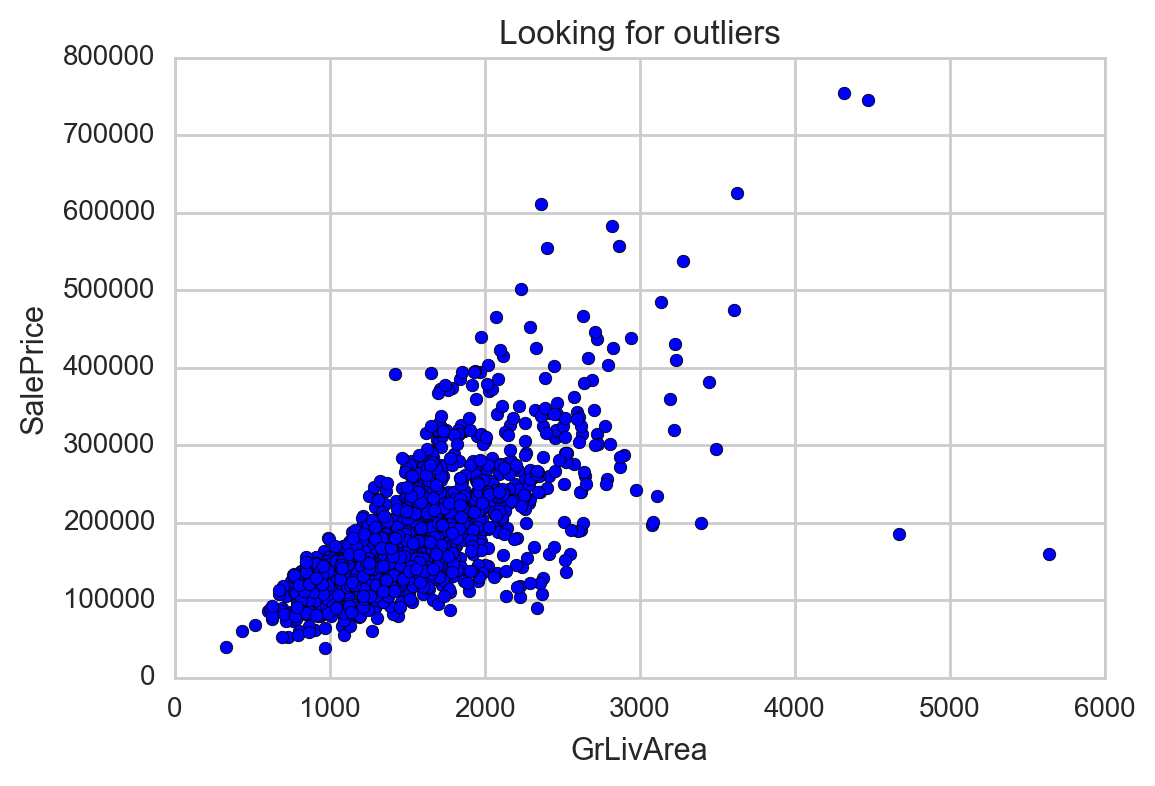

In [41]:
plt.scatter(house.GrLivArea, house.SalePrice)
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

Seems like houses above 4000sqft are the outliers, especially two that sold for a small price. I'm gonna get rid of them:

In [42]:
house = house[house["GrLivArea"] <4000]
house.shape

(1446, 78)

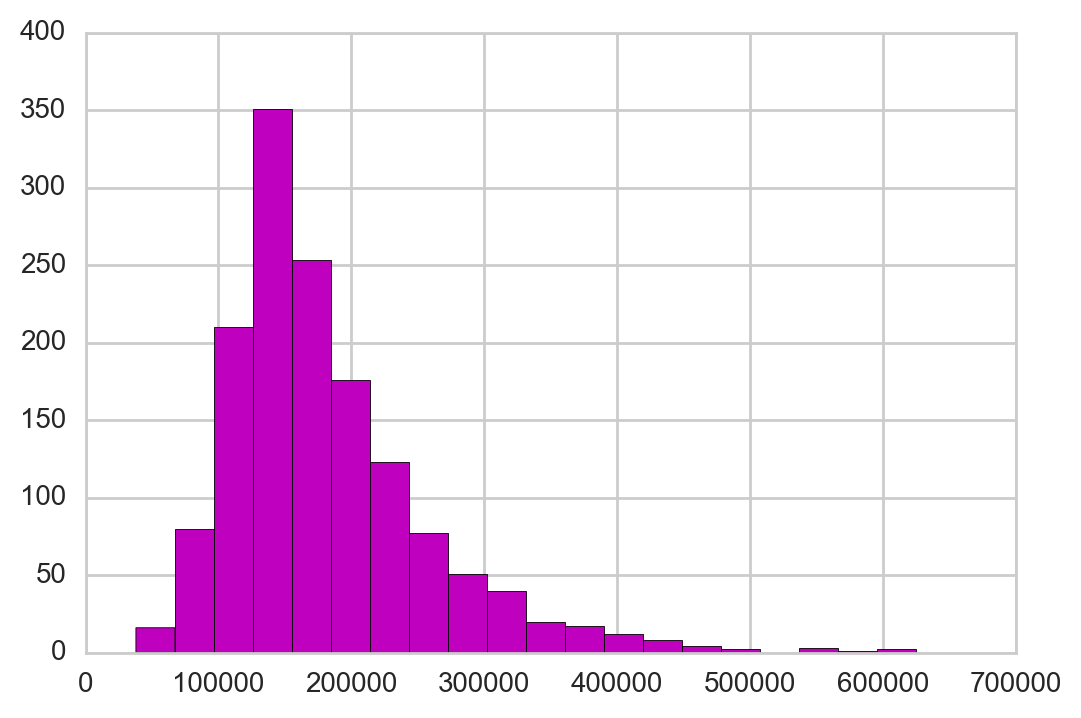

In [43]:
#Plotting SalePrice
plt.hist(house["SalePrice"], bins =20, color='m')
plt.show()

A bit skewed to the right. What about log transformation?

In [44]:
#applying log transformation
house['LogSalePrice'] = np.log(house['SalePrice'])

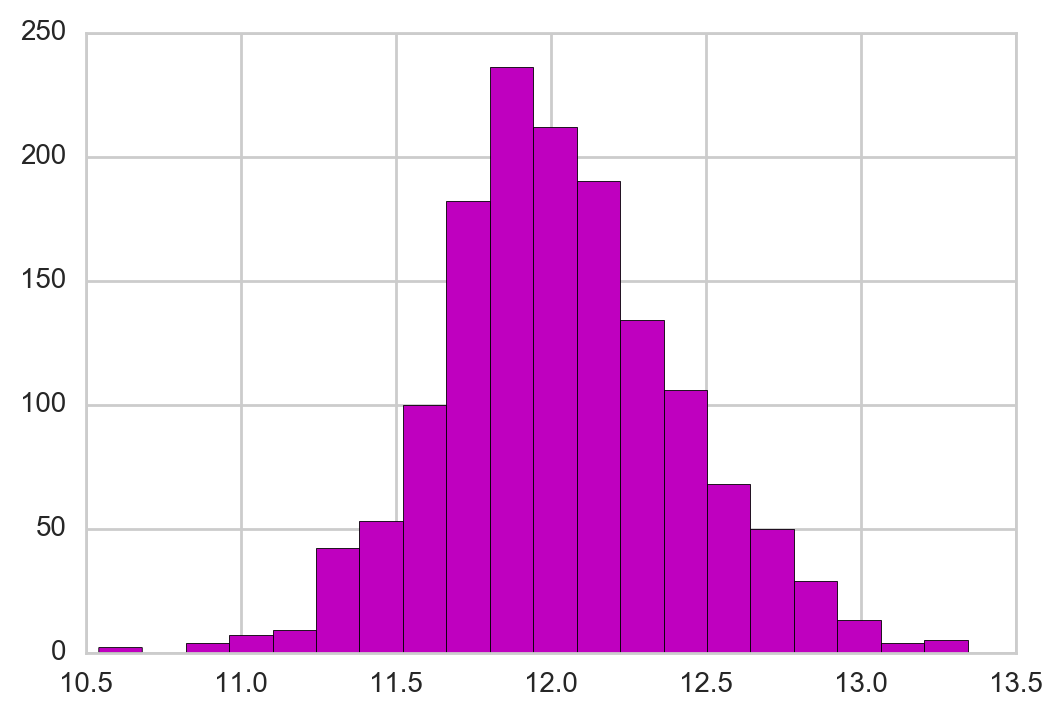

In [45]:
plt.hist(house["LogSalePrice"], bins =20, color='m')
plt.show()

That's better.

In [46]:
#Let's check correlations again, filtering insignificant ones out:
corr2 = house.corr()['SalePrice']
sign_corr = corr2[abs(corr2) > 0.3]
sign_corr.sort_values(ascending=False)
sign_corr

LotFrontage     0.360294
OverallQual     0.798954
YearBuilt       0.530009
YearRemodAdd    0.515539
BsmtFinSF1      0.393968
TotalBsmtSF     0.645274
1stFlrSF        0.622735
GrLivArea       0.720743
FullBath        0.554926
Fireplaces      0.463039
GarageArea      0.643874
WoodDeckSF      0.318834
OpenPorchSF     0.345063
SalePrice       1.000000
LogSalePrice    0.958274
Name: SalePrice, dtype: float64

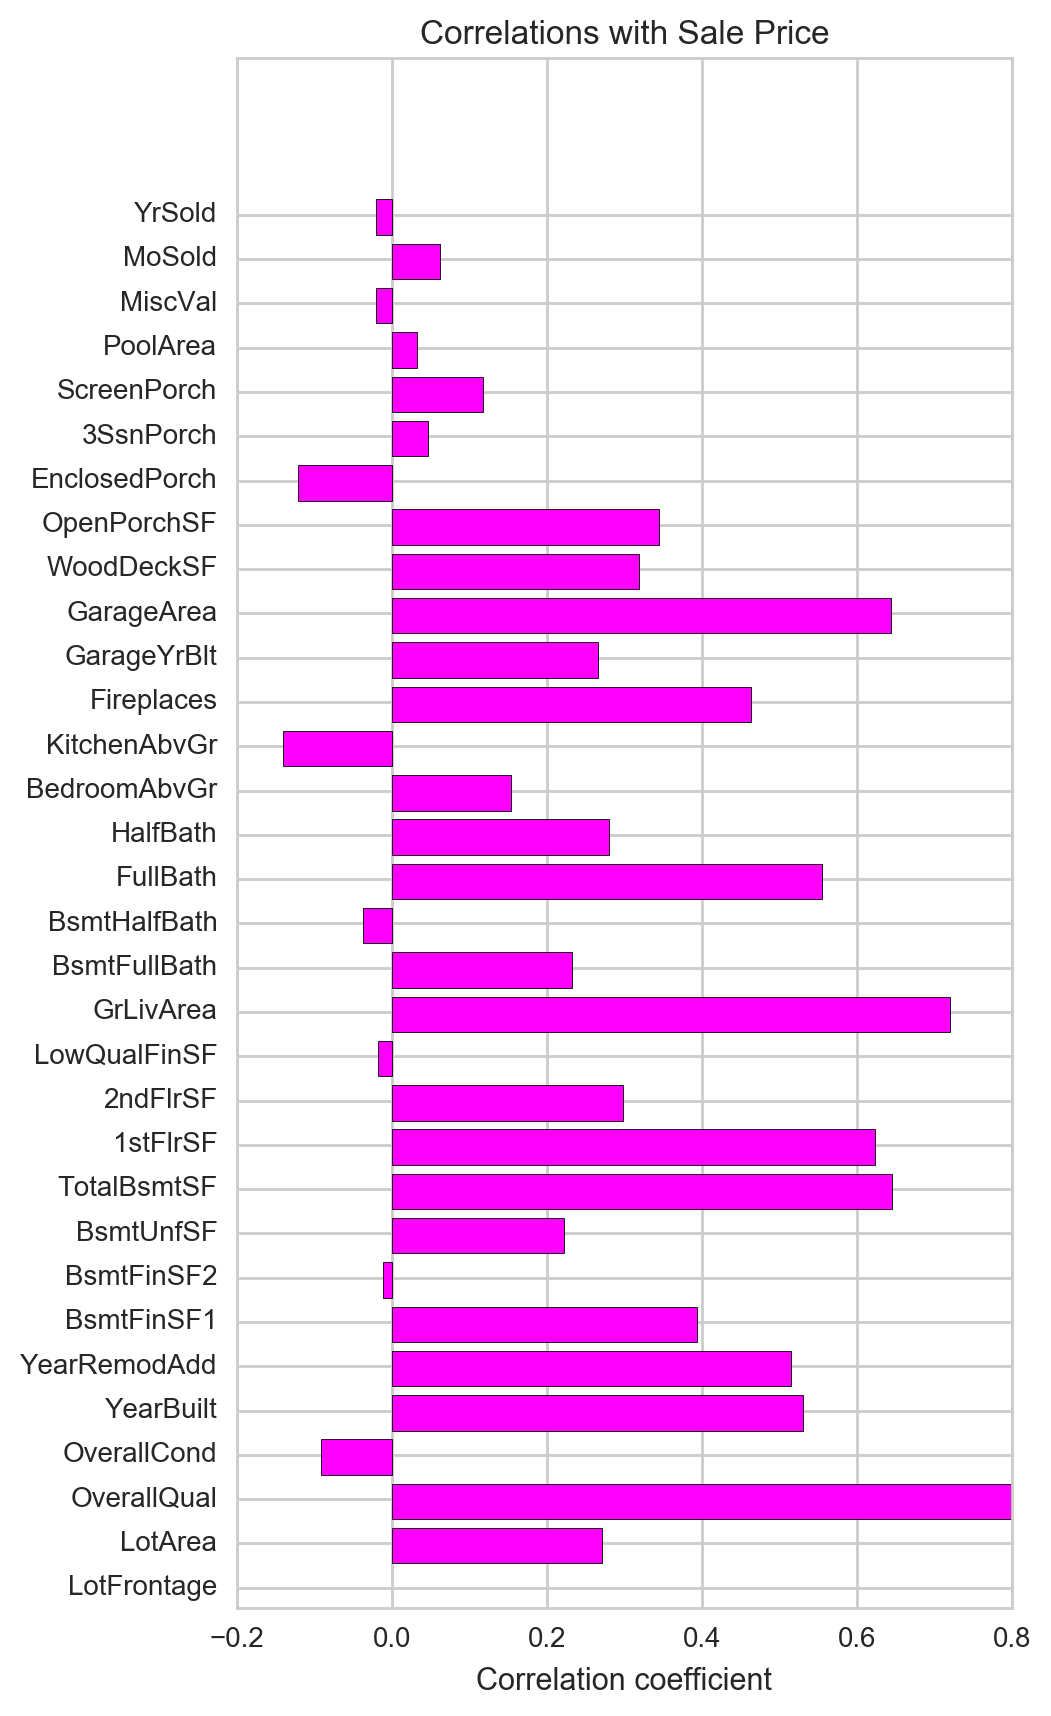

In [47]:
#plotting correlations
num_feat=house.columns[house.dtypes!=object]
num_feat=num_feat[1:-2] 
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(house[col].values, house.SalePrice.values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(5,10))
rects = ax.barh(ind, np.array(values), color='magenta')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlations with Sale Price");

The above plot visualises the positive and negative correlations with SalePrice column.

We can also see that columns related to the area of the house/lot are highly correlated with price, which makes sense. However some of these features have potential to be correlated between themselves so one needs to be careful. In fact, I'm going to create a new column, total area of the house so that later I can use  it in place of most other surface columns:

In [48]:
house["TotalHouseArea"] = house["GrLivArea"]+ house["TotalBsmtSF"] #feature saying how many floors there is
#try to create naive version with all the features, get the deltas between the scores of the models

#### 1.4 Preparing data for modelling:

Now it's time to pick columns that would help us answer the question number one, i.e. columns referring to fixed features of the house. From the data description we can see that first 14 features belong to "fixed" category. Let's create a list of fixed features:

In [49]:
fixed_features = house.columns[0:14].tolist()
fixed_features

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2']

From the data description we can further see that there is couple more fixed features further down the dataframe. Let's add them to the list, together with our target column, ie. SalePrice and LogSalePrice.

In [50]:
additional_columns = ['GrLivArea', 'Foundation', 'GarageArea', 'TotalBsmtSF', 'RoofStyle', 'YearBuilt',
                      '1stFlrSF', '2ndFlrSF', 'GarageType', 'GarageYrBlt', 'WoodDeckSF', 
                      'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                      'PoolArea', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
                      'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                      'HalfBath', 'Bedroom', 'Kitchen', 'MoSold', 'YrSold', 
                      'TotalHouseArea', 'SaleType', "SalePrice", 'LogSalePrice']

for c in additional_columns:
    fixed_features.append(c)
    
print fixed_features

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'GrLivArea', 'Foundation', 'GarageArea', 'TotalBsmtSF', 'RoofStyle', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'GarageType', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 'Kitchen', 'MoSold', 'YrSold', 'TotalHouseArea', 'SaleType', 'SalePrice', 'LogSalePrice']


Having read descriptions of the data and having looked at correlation plots above I decided to pick the following ones for my models:

In [51]:
chosen_fixed_cat_cols = ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'FullBath', 'BldgType', 'HouseStyle', 'TotalHouseArea']

Before I assign my X and Y, I need to look into splitting the data into train and test sections. Train section will contain pre-2010 sales and test will contain 2010 sales:

In [52]:
house.YrSold.value_counts()

2009    336
2007    325
2006    312
2008    301
2010    172
Name: YrSold, dtype: int64

In [53]:
#Sorting df by year of sale
house = house.sort_values(by='YrSold').reset_index(drop=True)
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice,TotalHouseArea
0,60,RL,65.0,7153,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,7,2006,WD,Normal,175900,12.077671,2364
1,60,RL,78.0,12011,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,0,6,2006,WD,Normal,280000,12.542545,3010
2,80,RL,92.0,6930,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,7,2006,WD,Abnorml,130000,11.775290,2414
3,50,RL,60.0,8400,Pave,0,Reg,Bnk,AllPub,Inside,...,0,0,0,6,2006,WD,Normal,140000,11.849398,2535
4,60,RL,118.0,35760,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,0,7,2006,WD,Normal,625000,13.345507,5557


In [54]:
#Look at first row where 2010 starts:
house[house.YrSold == 2010].index[0]

1274

Creating design matrix with patsy:

In [55]:
fix_feat = '~  C(MSSubClass) + C(MSZoning) + C(Neighborhood) + C(Condition1) + C(Condition2) + C(FullBath) + C(BldgType) + C(HouseStyle) +GarageArea + TotalHouseArea + -1'

X = patsy.dmatrix(fix_feat, data=house, return_type='dataframe')
y = house.LogSalePrice

print X.shape
print y.shape


(1446, 73)
(1446,)


Dividing into the train and test sets:

In [56]:
X_train = X.iloc[:1274,]
y_train = y.iloc[:1274,]

print X_train.shape
print y_train.shape

(1274, 73)
(1274,)


In [57]:
X_test = X.iloc[1274:,]
y_test = y.iloc[1274:,]

print X_test.shape
print y_test.shape

(172, 73)
(172,)


#### 1.5. Linear Regression

Train Score: 0.855368933899
 Test Score: 0.871517976436


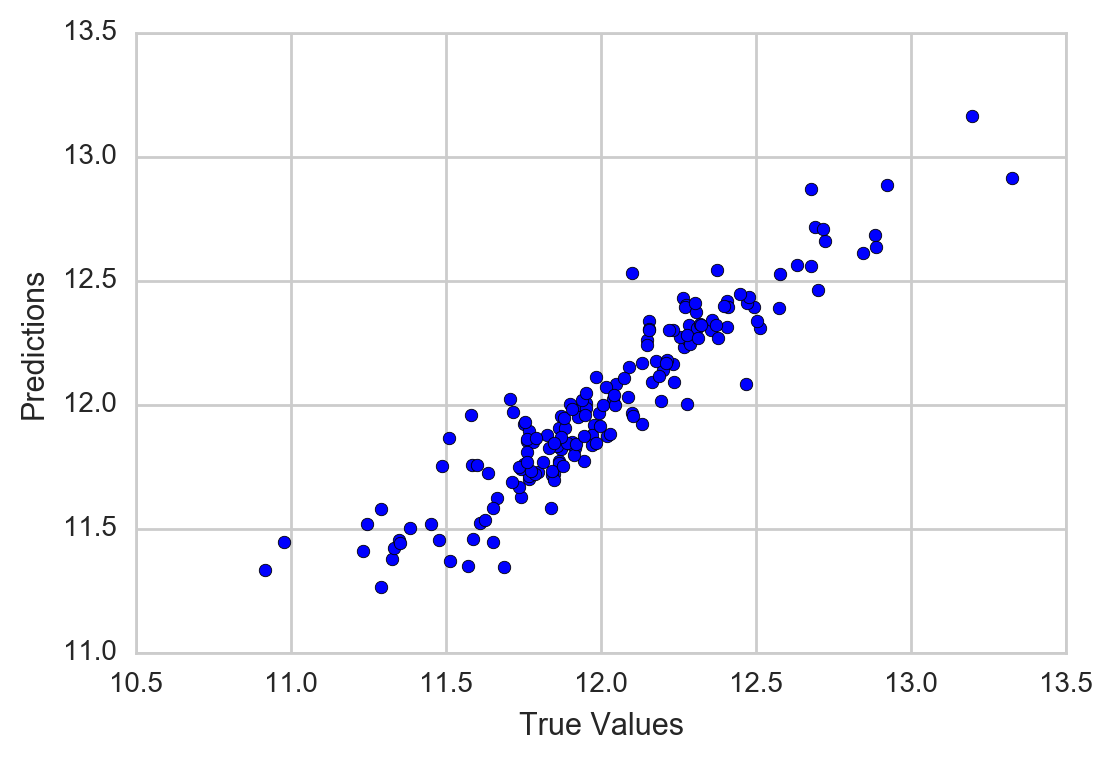

In [58]:
lm = LinearRegression()

model = lm.fit(X_train, y_train)
print "Train Score:", model.score(X_train, y_train) 

predictions = lm.predict(X_test)

# Plot the model
plt.scatter(y_test, predictions)

plt.xlabel("True Values")
plt.ylabel("Predictions")

print " Test Score:", model.score(X_test, y_test)  

Train score of my model is even higher than test score. As data for validation has been divided arbitrarily, not randomly, this could mean test data is "too easy" for the model.

In [59]:
#calculating mean squared error
mod_test_mse = mean_squared_error(y_test, predictions)
base_test_mse = mean_squared_error(y_test, np.tile(np.mean(y_test), len(y_test)))

print 'Model on test MSE:', mod_test_mse
print 'Baseline test MSE:', base_test_mse

Model on test MSE: 0.0199130367098
Baseline test MSE: 0.154986948037


In [60]:
#Get residuals
train_resid = y_train - lm.predict(X_train)
test_resid = y_test - predictions

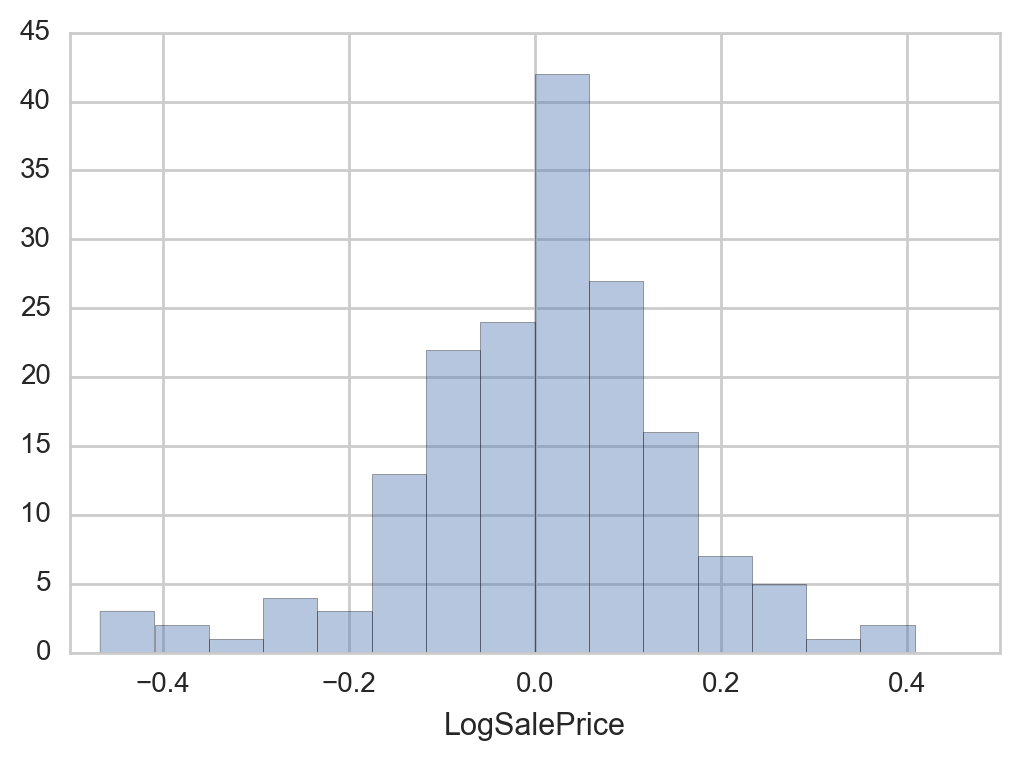

In [61]:
#Plot test residuals histogram
sns.distplot(test_resid, bins=15, hist=True, kde=False)
plt.show()

Residuals seem to be distributed close to normal, and most of them are very small.

In [62]:
#checking if we get same results using statsmodels:
#training data
smlm = sm.OLS(y_train.values, X_train).fit()
smlm.params
smlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     100.1
Date:                Sat, 13 May 2017   Prob (F-statistic):               0.00
Time:                        16:53:55   Log-Likelihood:                 632.00
No. Observations:                1274   AIC:                            -1120.
Df Residuals:                    1202   BIC:                            -749.2
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     10.9901      0.174     63.147      0.000      10.649      11.332
C(MSSubClass)[T.30]           -0.1882      0.027     -7.000      0.000      -0.241      -0.135
C(MSSubClass)[T.40]           -0.0530      0.093     -0.568      0.570      -0.236       0.130
C(MSSubClass)[T.45]           -0.3043      0.135     -2.256      0.024      -0.569      -0.040
C(MSSubClass)[T.50]           -0.1131      0.058     -1.957      0.051      -0.226       0.000
C(MSSubClass)[T.60]            0.0443      0.048      0.913      0.361      -0.051       0.139
C(MSSubClass)[T.70]           -0.0177      0.051     -0.343      0.731      -0.119       0.083
C(MSSubClass)[T.75]           -0.0389      0.095     -0.412      0.680      -0.224       0.146
C(MSSubClass)[T.80]           -0.0989      0.072     -1.367      0.172      -0.241       0.043
C(MSSubClass)[T.85]           -0.1438      0.067     -2.134      0.033      -0.276      -0.012
C(MSSubClass)[T.90]           -0.1095      0.015     -7.240      0.000      -0.139      -0.080
C(MSSubClass)[T.120]          -0.0146      0.091     -0.160      0.873      -0.194       0.165
C(MSSubClass)[T.160]          -0.1349      0.109     -1.239      0.216      -0.348       0.079
C(MSSubClass)[T.180]          -0.1533      0.123     -1.251      0.211      -0.394       0.087
C(MSSubClass)[T.190]           0.1531      0.159      0.961      0.337      -0.160       0.466
C(MSZoning)[T.RH]             -0.1334      0.059     -2.247      0.025      -0.250      -0.017
C(MSZoning)[T.RL]             -0.0225      0.042     -0.530      0.596      -0.106       0.061
C(MSZoning)[T.RM]             -0.0426      0.047     -0.905      0.366      -0.135       0.050
C(Neighborhood)[T.Blueste]    -0.0024      0.122     -0.020      0.984      -0.241       0.236
C(Neighborhood)[T.BrDale]     -0.1225      0.072     -1.714      0.087      -0.263       0.018
C(Neighborhood)[T.BrkSide]    -0.0728      0.057     -1.272      0.204      -0.185       0.039
C(Neighborhood)[T.ClearCr]     0.0098      0.055      0.178      0.859      -0.098       0.118
C(Neighborhood)[T.CollgCr]     0.0030      0.046      0.066      0.948      -0.087       0.093
C(Neighborhood)[T.Crawfor]     0.1052      0.052      2.039      0.042       0.004       0.206
C(Neighborhood)[T.Edwards]    -0.1263      0.049     -2.574      0.010      -0.223      -0.030
C(Neighborhood)[T.Gilbert]     0.0171      0.049      0.351      0.726      -0.078       0.112
C(Neighborhood)[T.IDOTRR]     -0.1373      0.066     -2.086      0.037      -0.266      -0.008
C(Neighborhood)[T.MeadowV]    -0.2610      0.071     -3.698      0.000      -0.400      -0.123
C(Neighborhood)[T.Mitchel]    -0.0833      0.050     -1.655      0.098      -0.182       0.015
C(Neighborhood)[T.NAmes]      -0.1174      

In [63]:
#test data:
smlm_predictions = smlm.predict(X_test)
smlm_test_mse = mean_squared_error(y_test, smlm_predictions)
smlm_test_mse

0.019913036709797393

The above mean squared error for test data is the same as in the scikit learn.

In [64]:
#In addition we can look at the p values of the features to assess their significance for our model:

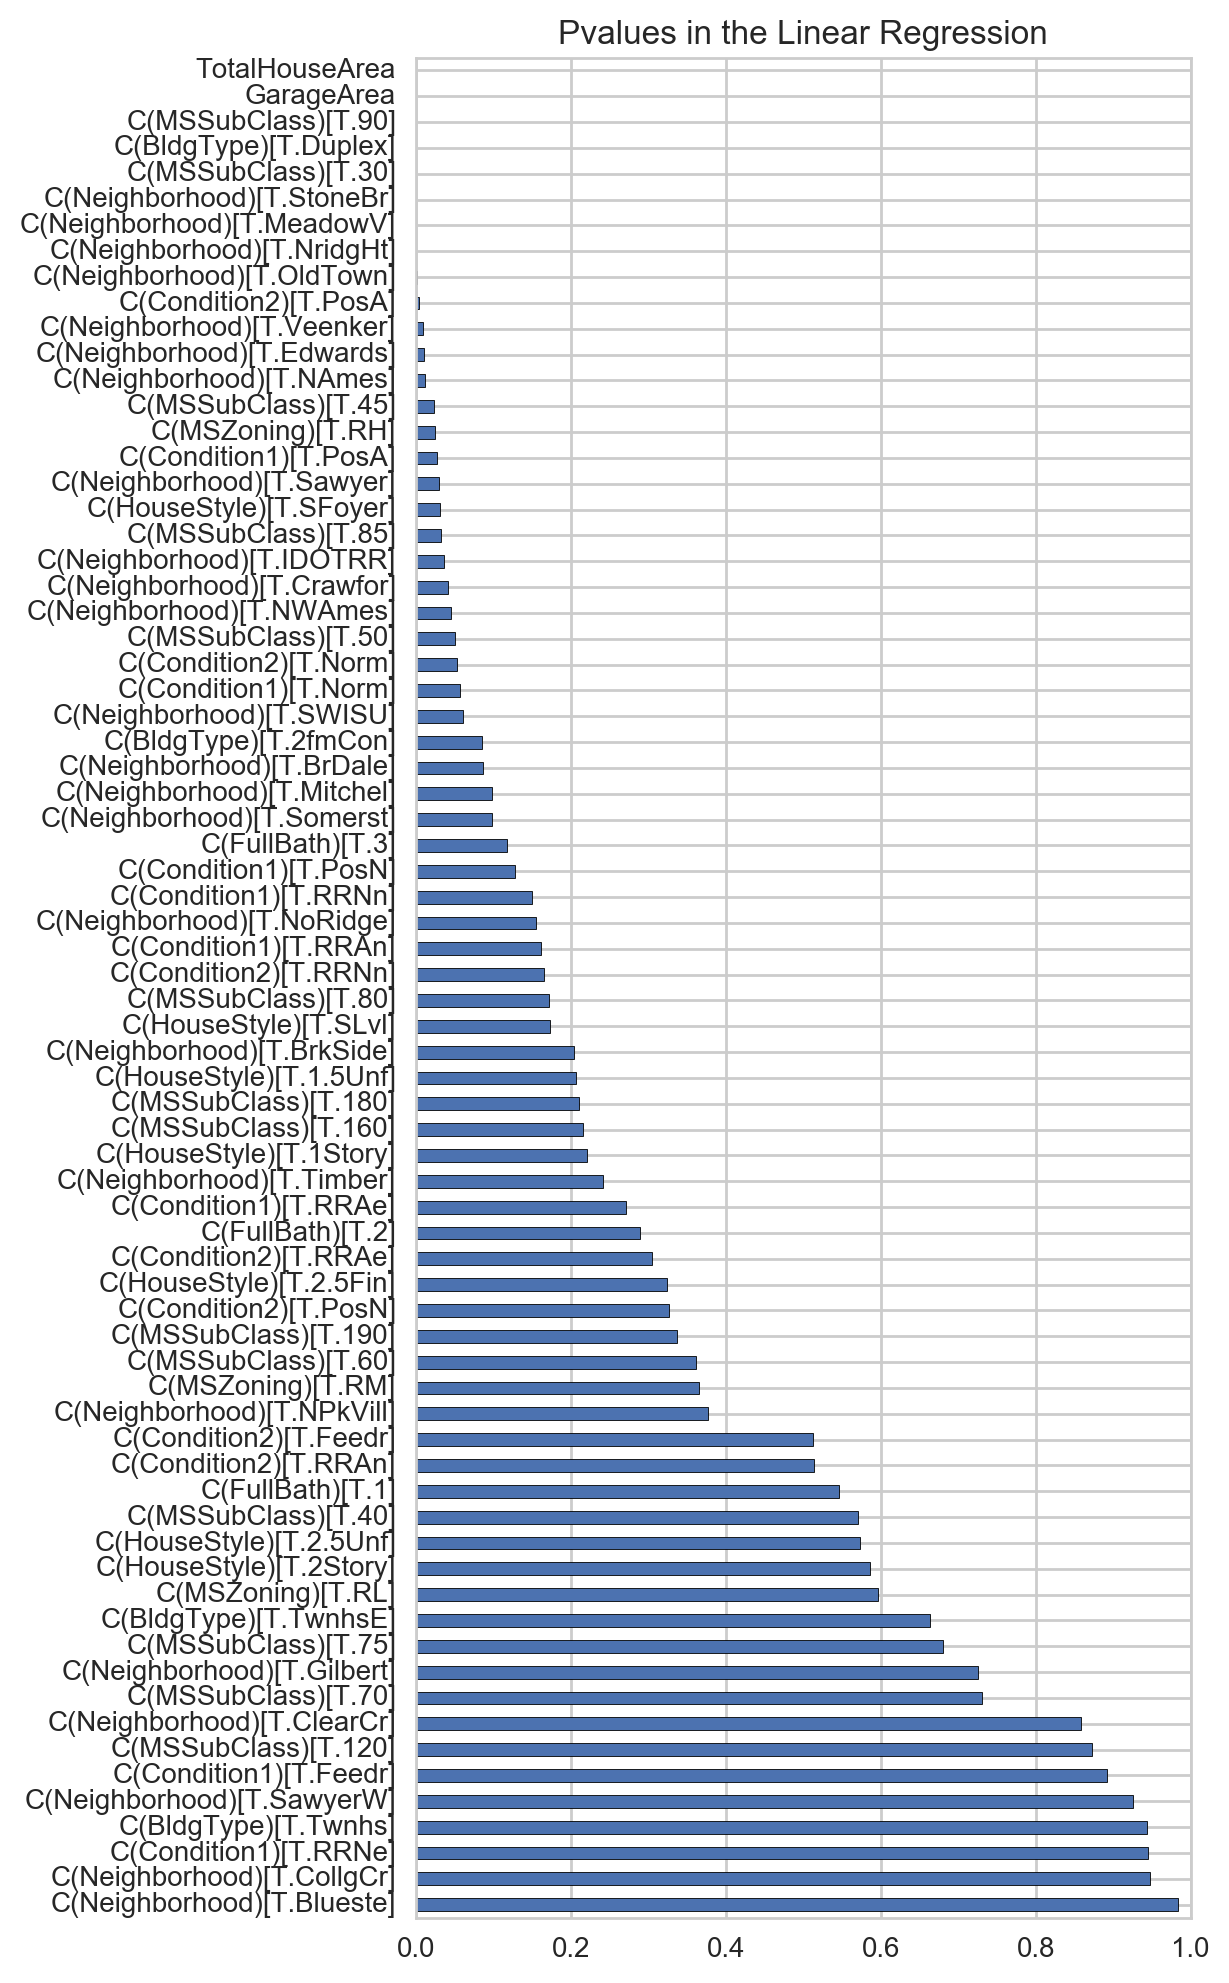

In [65]:
features = X.columns.tolist()[1:]
p_values = smlm.pvalues[1:]
p_values_df = pd.DataFrame({"p_values": p_values, "feature":features})
p_values_df = p_values_df.sort_values(by="p_values", ascending=False)

p_values_df.plot(kind = "barh", figsize=(5,12), legend=False)
plt.title("Pvalues in the Linear Regression")
plt.show()

So, the most important fixed features that influence the price in our model seem to be as follows:

In [66]:
p_values_df.sort_values(by="p_values", ascending=True).head(10)

,feature,p_values
TotalHouseArea,TotalHouseArea,5.511113e-138
GarageArea,GarageArea,7.362274e-24
C(MSSubClass)[T.90],C(MSSubClass)[T.90],8.005062e-13
C(BldgType)[T.Duplex],C(BldgType)[T.Duplex],8.005062e-13
C(MSSubClass)[T.30],C(MSSubClass)[T.30],4.237912e-12
C(Neighborhood)[T.StoneBr],C(Neighborhood)[T.StoneBr],4.058681e-05
C(Neighborhood)[T.MeadowV],C(Neighborhood)[T.MeadowV],2.267232e-04
C(Neighborhood)[T.NridgHt],C(Neighborhood)[T.NridgHt],2.640527e-04
C(Neighborhood)[T.OldTown],C(Neighborhood)[T.OldTown],1.651680e-03
C(Condition2)[T.PosA],C(Condition2)[T.PosA],4.465647e-03


We can see that square footage of the house and garage have the highest significance in influencing the house price. The other influencial features are the buidling/dwelling type/class and neighbourhood.

The above model gives us answers, but it's quite complex. I'm going to try Lasso regression in order to check if we can drop some features but keep the high score.

Let's try Lasso:

In [67]:
#standardize X matrix:
ss = StandardScaler()
Xn = ss.fit_transform(X)

In [106]:
#Prepare a range of alpha values to test
alphas = np.logspace(-10,10,21)

#Create a dictionary with the gridsearch parameters
params = {'alpha': alphas}

#Create and Fit a Lasso Regression Model, Testing Each Alpha
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=params)
grid.fit(Xn,y)

print "Grid:\n", grid
print 
#Summarize the Results of the Grid Search
print "Best score:\n", grid.best_score_
print "Best estimator alpha: \n", grid.best_estimator_.alpha

Grid:
GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best score:
0.840336548537
Best estimator alpha: 
0.001


In [69]:
lasso = Lasso(alpha=0.001)

lasso_scores = cross_val_score(lasso, Xn, y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

[ 0.87315862  0.83516125  0.84007929  0.81297481  0.86527746  0.83265439
  0.80374021  0.79499556  0.86494592  0.87272289]
0.839571040919


In [70]:
lasso.fit(Xn, y)

lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(10)

,abs_coef,coef,variable
72,0.201658,0.201658,TotalHouseArea
71,0.063663,0.063663,GarageArea
33,0.042131,0.042131,C(Neighborhood)[T.NridgHt]
1,0.039980,-0.039980,C(MSSubClass)[T.30]
34,0.035493,-0.035493,C(Neighborhood)[T.OldTown]
10,0.034419,-0.034419,C(MSSubClass)[T.90]
5,0.034030,0.034030,C(MSSubClass)[T.60]
29,0.032062,-0.032062,C(Neighborhood)[T.NAmes]
38,0.029073,0.029073,C(Neighborhood)[T.Somerst]
39,0.028818,0.028818,C(Neighborhood)[T.StoneBr]


In [71]:
lasso_coefs[lasso_coefs["abs_coef"] !=0].shape

(56, 3)

In [72]:
print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(Xn.shape[0])

Percent variables zeroed out: 0.0117565698479


Lasso ended up surpressing only 1% of the features and the best score for lasso is 0.84.  It is lower than the one for the linear regression on test values, so I'm going ahead with linear regression as my best model, however the list of the coefficients in Lasso suggest similar features as the most influencing as linear regression.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

Getting residuals from the first model:

In [73]:
#Get residuals
train_resid = y_train - lm.predict(X_train)
test_resid = y_test - predictions

lm_residuals = train_resid
lm_residuals.append(test_resid)
lm_residuals.shape
#lm_residuals

(1274,)

In [74]:
house["lm_residuals"] = lm_residuals

In [75]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice,TotalHouseArea,lm_residuals
0,60,RL,65.0,7153,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,7,2006,WD,Normal,175900,12.077671,2364,-0.048704
1,60,RL,78.0,12011,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,6,2006,WD,Normal,280000,12.542545,3010,0.145262
2,80,RL,92.0,6930,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,7,2006,WD,Abnorml,130000,11.775290,2414,-0.280127
3,50,RL,60.0,8400,Pave,0,Reg,Bnk,AllPub,Inside,...,0,0,6,2006,WD,Normal,140000,11.849398,2535,0.023533
4,60,RL,118.0,35760,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,7,2006,WD,Normal,625000,13.345507,5557,0.172187


In [76]:
#Looking for changeable features in the dataset:
house.columns.tolist()

#From data description I found the following columns that refer to quality of the house:

changeable_features = ["OverallQual", "OverallCond", "ExterQual", 'ExterCond', 'BsmtQual', "BsmtCond", 'BsmtFinType1', 
                       'BsmtFinType2', 'HeatingQC', 'CentralAir','KitchenQual', 'Functional', 'GarageQual',
                       'GarageCond', 'PoolQC']
len(changeable_features)

15

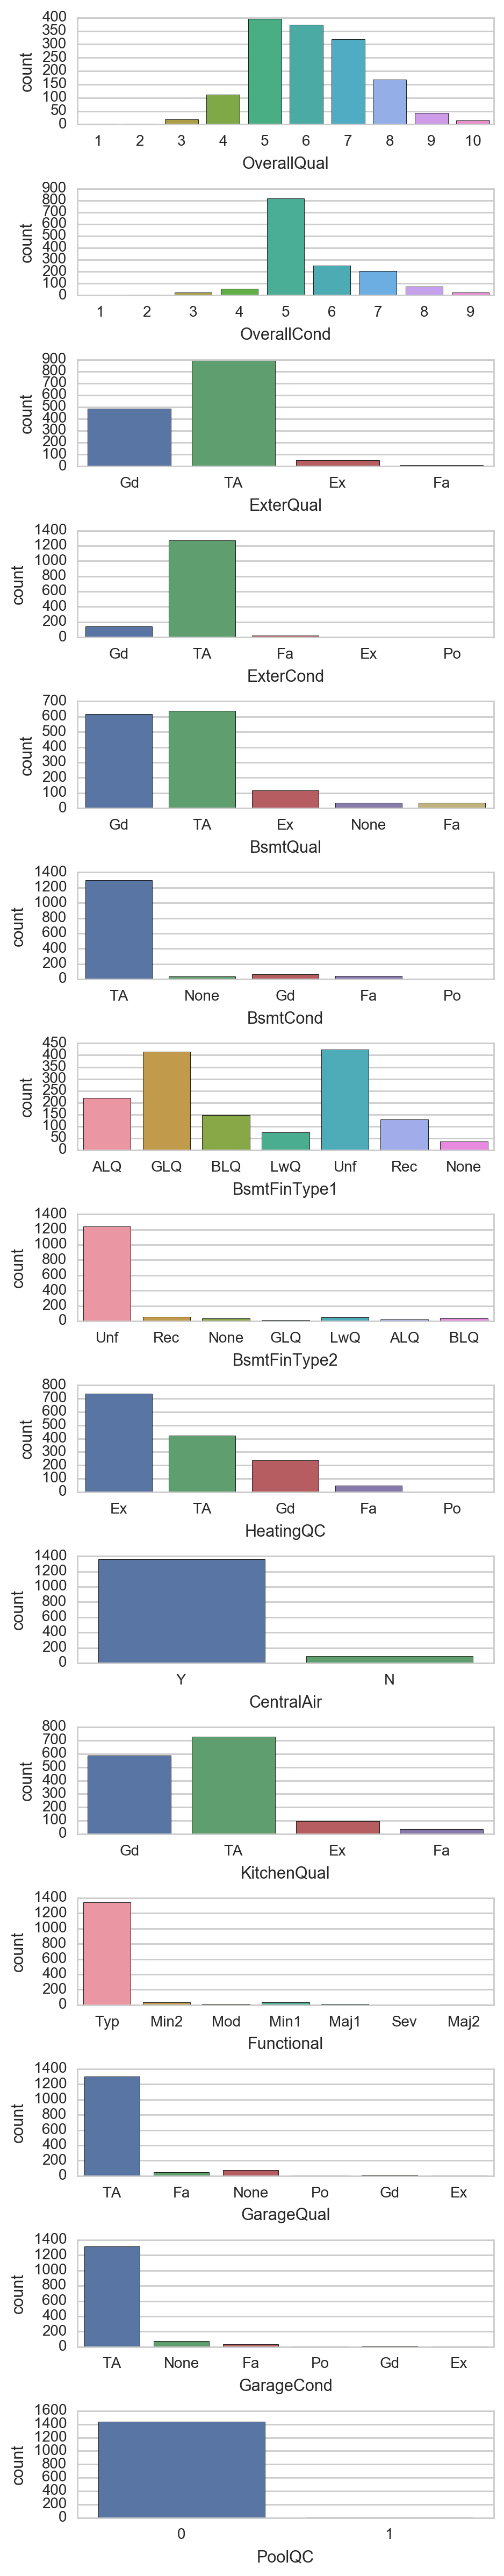

In [77]:
#As all of the above are categorical variables, I want to check how the distribution of categories looks like:
fig, axs = plt.subplots(15,1, figsize=(5, 30))
plt.subplots_adjust(hspace= .6)

for i in range(0,len(changeable_features)):
    sns.countplot(house[changeable_features[i]], ax=axs[i])
    ax.title = changeable_features[i]


Looking at the plots, I'm going to keep all these features. I'm tempted to narrow down some categories (for example in KitchenQual we could go with binary categories Typical - NonTypical) but I think I could lose some good insights so I'll leave them as they are for the time being.

In [78]:
#Setting up patsy matrix and target:
changeable_feat = '~ C(OverallQual) + C(OverallCond) + C(ExterQual) + C(ExterCond) + C(BsmtQual) + C(BsmtCond) + C(BsmtFinType1) + C(BsmtFinType2) + C(HeatingQC) + C(CentralAir) + C(KitchenQual) + C(Functional) +C(GarageQual) + C(GarageCond) + C(PoolQC) + -1'

X_r = patsy.dmatrix(changeable_feat, data=house, return_type='dataframe')
y_r = house.lm_residuals

print X_r.shape
print y_r.shape


(1446, 70)
(1446,)


In [79]:
#Standardize X matrix:
ss = StandardScaler()
X_rn = ss.fit_transform(X_r)

Using GridSearch to find optimal parameters:

In [80]:
#Prepare a range of alpha values to test
alphas = np.logspace(-10,10,21)

#Create a dictionary with the gridsearch parameters
params = {'alpha': alphas}

#Create and Fit a Ridge Regression Model, Testing Each Alpha
model = Ridge( )
grid = GridSearchCV(estimator=model, param_grid=params)
grid.fit(X_rn,y)

print "Grid:\n", grid
print 
#Summarize the Results of the Grid Search
print "Best score:\n", grid.best_score_
print "Best estimator alpha: \n", grid.best_estimator_.alpha

Grid:
GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best score:
0.731164341392
Best estimator alpha: 
100.0


In [81]:
#Ridge using best estimator:

ridge = Ridge(alpha=100)

ridge_scores = cross_val_score(ridge, X_rn, y, cv=5)

print ridge_scores
print np.mean(ridge_scores)

[ 0.7555754   0.7156815   0.71457681  0.74786281  0.73013242]
0.732765788843


In [82]:
ridge.fit(X_rn, y)

ridge_coefs = pd.DataFrame({'variable':X_r.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(20)

,abs_coef,coef,variable
7,0.095706,0.095706,C(OverallQual)[T.8]
8,0.082353,0.082353,C(OverallQual)[T.9]
28,0.070366,-0.070366,C(BsmtQual)[T.TA]
3,0.070107,-0.070107,C(OverallQual)[T.4]
4,0.069745,-0.069745,C(OverallQual)[T.5]
9,0.061774,0.061774,C(OverallQual)[T.10]
52,0.056941,-0.056941,C(KitchenQual)[T.TA]
6,0.042991,0.042991,C(OverallQual)[T.7]
2,0.039747,-0.039747,C(OverallQual)[T.3]
20,0.038560,-0.038560,C(ExterQual)[T.TA]


From the above we can see that the best features company could invest in are the ones referring to the overall quality of the house in the first place. Next, Basement, Kitchen and Exterior have the biggest influence on the price.

The two models can help company to make decision how to invest their money based on type, size and location of the building and also which easy reparable features could give them the best return of investment.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?
Determine which features predict the `Abnorml` category in the `SaleCondition` feature.

Checking for target class distribution:

In [83]:
house.SaleCondition.value_counts()

Normal     1193
Partial     123
Abnorml      95
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

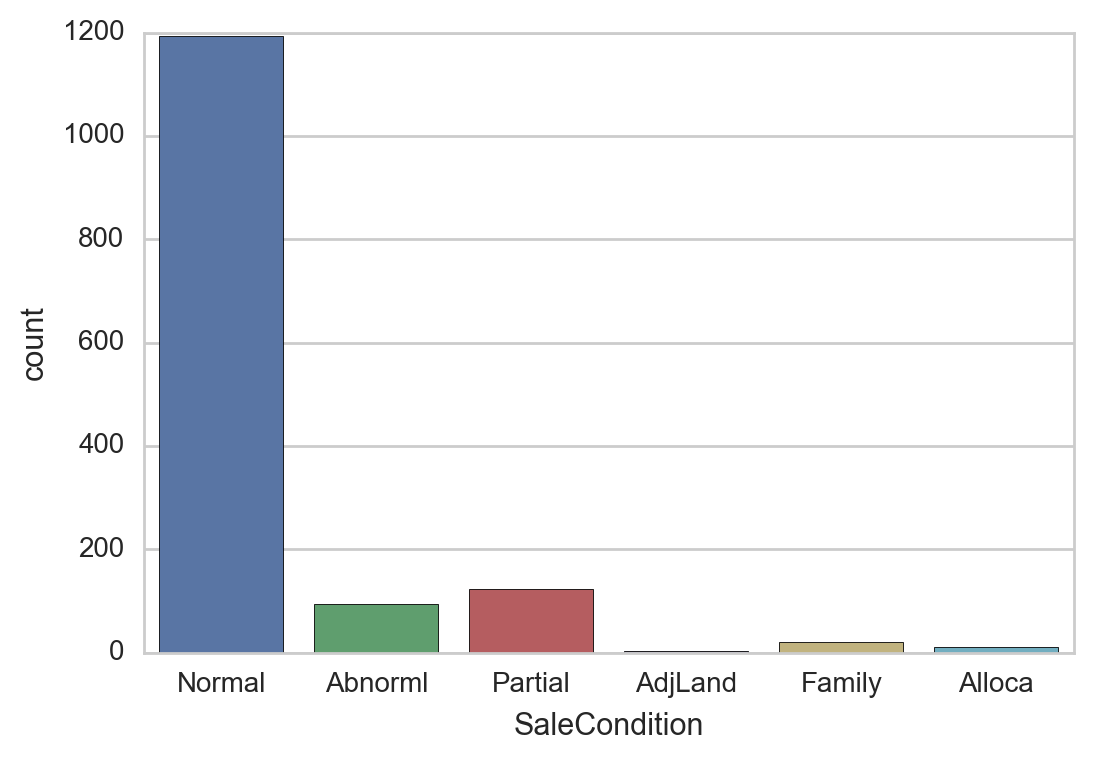

In [84]:
sns.countplot(house.SaleCondition)
plt.show()

It is very imbalanced set indeed. From what I found out online one of the ways to deal with it would be to divide majority class into smaller classes, based on some other features. Here however the imbalance is so large, that I would probably need to divide the largest class ("Normal") into 10 new classes. 

I'm going to try undersampling instead. From the "Normal" and "Partial" classes I'm going to randomly pick 100 samples each and proceed with classification. I'm also going to merge 3 least common classes into one, called "Other".

In [85]:
#Adding smaller classes to a new df
class_house_df = house[(house["SaleCondition"] == "Abnorml") 
                      | (house["SaleCondition"] == "AdjLand") 
                        | (house["SaleCondition"] == "Family")
                      | (house["SaleCondition"] == "Alloca")
                      ]

In [86]:
class_house_df.shape

(130, 81)

In [87]:
#Replacing small classes name with "Other":
class_house_df.loc[:,'SaleCondition'] = class_house_df.SaleCondition.map(lambda x: "Other" if x == "Family" else x) 
class_house_df.loc[:,'SaleCondition'] = class_house_df.SaleCondition.map(lambda x: "Other" if x == 'Alloca' else x)
class_house_df.loc[:,'SaleCondition'] = class_house_df.SaleCondition.map(lambda x: "Other" if x == 'AdjLand' else x)

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [88]:
class_house_df.SaleCondition.value_counts()


Abnorml    95
Other      35
Name: SaleCondition, dtype: int64

In [89]:
#Adding sample of 100 "Normal" and "Partial" sales to the new df
class_house_df = class_house_df.append(house[house["SaleCondition"] == "Normal"].sample(n=100, replace=False, random_state=42))
class_house_df = class_house_df.append(house[house["SaleCondition"] == "Partial"].sample(n=100, replace=False, random_state=42))


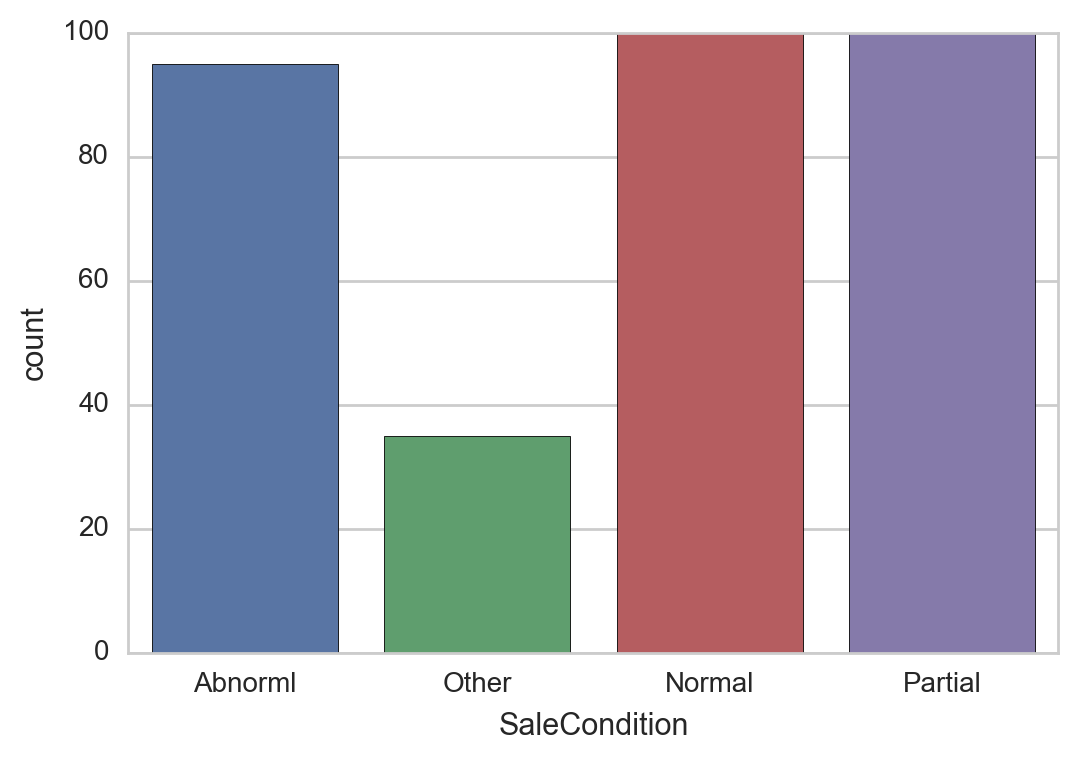

In [90]:
sns.countplot(class_house_df.SaleCondition)
plt.show()

Ok, that's better. I'm not sure whether "Other" category is large enough, but I'm going to keep it for the time being and go ahead with the classification.

In [91]:
#changing strings to numbers in SaleCond column
#{'Abnorml':1, 'Other':2, 'Normal':3, 'Partial':4}
class_house_df.loc[:,'SaleCondition'] = class_house_df.SaleCondition.map(lambda x: 1 if x == "Abnorml" else 2 if x == 'Other' else 3 if x == "Normal" else 4)

In [92]:
#choosing predictors:
class_house_df.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'Functional', u'Fireplaces', u'FireplaceQu', u'GarageType',
       u'GarageYrBlt', u'GarageFinish', u'GarageArea', u'GarageQual',


In [93]:
#drop columns that are repetitive/not needed: (also LotFrontage as it's causing trouble in Patsy)
cols_to_drop = ['lm_residuals', 'LogSalePrice', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'LotFrontage']
class_house_df.drop(cols_to_drop, axis=1, inplace=True)

In [94]:
class_house_df.shape

(330, 70)

In [95]:
#resetting index
class_house_df  = class_house_df.reset_index(drop=True)

In [96]:
#I have to rename one of the columns as it's causing trouble in patsy
class_house_df.columns = [c.replace('3', 'Three') for c in class_house_df.columns]
class_house_df.columns

Index([u'MSSubClass', u'MSZoning', u'LotArea', u'Street', u'Alley',
       u'LotShape', u'LandContour', u'Utilities', u'LotConfig', u'LandSlope',
       u'Neighborhood', u'Condition1', u'Condition2', u'BldgType',
       u'HouseStyle', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'RoofStyle', u'RoofMatl', u'Exterior1st',
       u'Exterior2nd', u'MasVnrType', u'MasVnrArea', u'ExterQual',
       u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'BsmtFullBath', u'BsmtHalfBath',
       u'FullBath', u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr',
       u'KitchenQual', u'Functional', u'Fireplaces', u'FireplaceQu',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageArea',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'WoodDeckSF',
       u'OpenPorchSF', u'EnclosedPorch', u'ThreeSsnPorch', u'ScreenPorch',
       u'PoolArea', 

In [97]:
ch_columns = class_house_df.columns.tolist()
print ch_columns

['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'TotalHouseArea']


In [98]:
#separating continouos categories
cont_cats = [x for x in ch_columns if "Area" in x or "Porch" in x or "Deck" in x 
             or "SalePrice" in x or "SaleCondition" in x ]

print cont_cats
#and categorical categories
cat_cats = [x for x in ch_columns if x not in cont_cats]

#now remove target column
cont_cats.remove("SaleCondition")

['LotArea', 'MasVnrArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'SaleCondition', 'SalePrice', 'TotalHouseArea']


In [99]:
#preparing features for patsy:
formula =  '~ '+' + '.join(cont_cats + ['C('+x+')' for x in cat_cats])+'-1'
formula

'~ LotArea + MasVnrArea + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + SalePrice + TotalHouseArea + C(MSSubClass) + C(MSZoning) + C(Street) + C(Alley) + C(LotShape) + C(LandContour) + C(Utilities) + C(LotConfig) + C(LandSlope) + C(Neighborhood) + C(Condition1) + C(Condition2) + C(BldgType) + C(HouseStyle) + C(OverallQual) + C(OverallCond) + C(YearBuilt) + C(YearRemodAdd) + C(RoofStyle) + C(RoofMatl) + C(Exterior1st) + C(Exterior2nd) + C(MasVnrType) + C(ExterQual) + C(ExterCond) + C(Foundation) + C(BsmtQual) + C(BsmtCond) + C(BsmtExposure) + C(BsmtFinType1) + C(BsmtFinType2) + C(Heating) + C(HeatingQC) + C(CentralAir) + C(Electrical) + C(BsmtFullBath) + C(BsmtHalfBath) + C(FullBath) + C(HalfBath) + C(BedroomAbvGr) + C(KitchenAbvGr) + C(KitchenQual) + C(Functional) + C(Fireplaces) + C(FireplaceQu) + C(GarageType) + C(GarageYrBlt) + C(GarageFinish) + C(GarageQual) + C(GarageCond) + C(PavedDrive) + C(PoolQC) + C(Fence) + C(MiscFeature) + 

In [100]:
#patsy matrix
X_sc = patsy.dmatrix(formula, data=class_house_df, return_type='dataframe')
X_sc.shape

(330, 586)

In [101]:
#target
y_sc = class_house_df.SaleCondition
y_sc.shape

(330,)

In [102]:
#train/test split
X_sc_train, X_sc_test, y_sc_train, y_sc_test = train_test_split(X_sc, y_sc, test_size=0.4)

In [103]:
model = LogisticRegression()

In [104]:
print cross_val_score(model,X_sc,y_sc,cv=5).mean()
print 
 

conf_m = pd.DataFrame(confusion_matrix(y_sc,cross_val_predict(model,X_sc,y_sc,cv=5),labels=[1,2,3,4]),
                   index=range(1,5),columns=range(1,5))
print conf_m
print 
print classification_report(y_sc,cross_val_predict(model,X_sc,y_sc,cv=5))

0.548484848485

    1  2   3   4
1  52  1  34   8
2  18  0  11   6
3  35  2  37  26
4   3  0   5  92

             precision    recall  f1-score   support

          1       0.48      0.55      0.51        95
          2       0.00      0.00      0.00        35
          3       0.43      0.37      0.40       100
          4       0.70      0.92      0.79       100

avg / total       0.48      0.55      0.51       330

